--- Starting Model Training Process ---
Loading dataset from: Final_Augmented_dataset_Diseases_and_Symptoms.csv...
Dataset loaded successfully.
Identifying and removing diseases with only one sample...
Removed 1 rows corresponding to rare diseases.
Cleaned dataset shape: (33962, 378)
Separating features (symptoms) and target (disease)...
Encoding text-based disease names into numerical labels...
Splitting data into training (80%) and testing (20%) sets...
Data split complete.
Initializing and training the memory-optimized RandomForestClassifier...
Model training completed!
Model and encoder saved successfully.

--- Model Evaluation ---
Overall Accuracy: 0.9168

Classification Report:


ValueError: Number of classes, 109, does not match size of target_names, 111. Try specifying the labels parameter

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import joblib
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

file_path = "/content/Final_Augmented_dataset_Diseases_and_Symptoms.csv"

def train_disease_prediction_model(file_path):
    """
    Loads data, cleans it, trains a memory-optimized model,
    evaluates it, and saves the model and encoder.
    """
    print("--- Starting Model Training Process ---")

    # --- 1. Load the Dataset ---
    try:
        print(f"Loading dataset from: {file_path}...")
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file was not found at {file_path}")
        return
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return

    print("Dataset loaded successfully.")

    # --- 2. Clean Data: Remove Rare Diseases ---
    print("Identifying and removing diseases with only one sample...")
    disease_counts = df['diseases'].value_counts()
    diseases_to_keep = disease_counts[disease_counts >= 2].index

    original_rows = len(df)
    df_cleaned = df[df['diseases'].isin(diseases_to_keep)]
    cleaned_rows = len(df_cleaned)

    print(f"Removed {original_rows - cleaned_rows} rows corresponding to rare diseases.")
    print(f"Cleaned dataset shape: {df_cleaned.shape}")

    if df_cleaned.empty:
        print("Error: No data left after cleaning. Please check your dataset.")
        return

    # --- 3. Separate Features (X) and Target (y) ---
    print("Separating features (symptoms) and target (disease)...")
    y = df_cleaned['diseases']
    X = df_cleaned.drop('diseases', axis=1)

    # --- 4. Encode the Target Variable ---
    print("Encoding text-based disease names into numerical labels...")
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # --- 5. Split Data into Training and Testing Sets ---
    print("Splitting data into training (80%) and testing (20%) sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    print("Data split complete.")

    # --- 6. Initialize and Train the Model ---
    print("Initializing and training the memory-optimized RandomForestClassifier...")
    model = RandomForestClassifier(
        n_estimators=50,
        max_depth=20,
        random_state=42,
        n_jobs=1
    )
    model.fit(X_train, y_train)
    print("Model training completed!")

    # --- 7. Save the Model and Encoder ---
    joblib.dump(model, 'disease_prediction_model.joblib')
    joblib.dump(label_encoder, 'disease_label_encoder.joblib')
    print("Model and encoder saved successfully.")

    # --- 8. Make Predictions and Evaluate ---
    print("\n--- Model Evaluation ---")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")

    # ==> MODIFIED LINES TO FIX THE VALUEERROR <==
    # Get the unique labels that are actually present in the test and prediction sets
    present_labels = np.unique(np.concatenate((y_test, y_pred)))
    # Get the corresponding names for these labels from the encoder
    target_names_present = label_encoder.inverse_transform(present_labels)

    # Generate the report using only the labels and names that are actually present
    print(classification_report(y_test, y_pred, labels=present_labels, target_names=target_names_present, zero_division=0))

    print("\n--- Process Finished ---")


if __name__ == '__main__':
    csv_file_path = "Final_Augmented_dataset_Diseases_and_Symptoms.csv"
    train_disease_prediction_model(csv_file_path)

--- Starting Model Training Process ---
Loading dataset from: Final_Augmented_dataset_Diseases_and_Symptoms.csv...
Dataset loaded successfully.
Identifying and removing diseases with only one sample...
Removed 17 rows corresponding to rare diseases.
Cleaned dataset shape: (219810, 378)
Separating features (symptoms) and target (disease)...
Encoding text-based disease names into numerical labels...
Splitting data into training (80%) and testing (20%) sets...
Data split complete.
Initializing and training the memory-optimized RandomForestClassifier...
Model training completed!
Model and encoder saved successfully.

--- Model Evaluation ---
Overall Accuracy: 0.6203

Classification Report:
                                                          precision    recall  f1-score   support

                                        abdominal hernia       1.00      0.56      0.71        81
                                         abscess of nose       1.00      0.71      0.83        58
          

In [5]:
##XGboost

In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
import joblib
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

file_path = "/content/Final_Augmented_dataset_Diseases_and_Symptoms.csv"

def train_disease_prediction_model(file_path):
    """
    Loads data, cleans it, and trains a high-performance XGBoost model
    with class weighting to handle imbalances.
    """
    print("--- Starting High-Performance Model Training Process ---")

    # --- 1. Load the Dataset ---
    try:
        print(f"Loading dataset from: {file_path}...")
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file was not found at {file_path}")
        return
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return

    print("Dataset loaded successfully.")

    # --- 2. Clean Data: Remove Rare Diseases ---
    print("Identifying and removing diseases with only one sample...")
    disease_counts = df['diseases'].value_counts()
    diseases_to_keep = disease_counts[disease_counts >= 2].index
    df_cleaned = df[df['diseases'].isin(diseases_to_keep)]
    print(f"Cleaned dataset shape: {df_cleaned.shape}")

    if df_cleaned.empty:
        print("Error: No data left after cleaning.")
        return

    # --- 3. Separate Features (X) and Target (y) ---
    print("Separating features and target...")
    y = df_cleaned['diseases']
    X = df_cleaned.drop('diseases', axis=1)

    # --- 4. Encode the Target Variable ---
    print("Encoding disease names into numerical labels...")
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # --- 5. Split Data into Training and Testing Sets ---
    print("Splitting data into training (80%) and testing (20%) sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    print("Data split complete.")

    # --- 6. [NEW] Calculate Sample Weights for Imbalance ---
    print("Calculating sample weights to handle class imbalance...")
    # This gives more importance to samples from rare classes
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # --- 7. [NEW] Initialize and Train the XGBoost Model ---
    print("Initializing and training the XGBoost Classifier...")
    # XGBoost is a powerful gradient boosting model
    model = xgb.XGBClassifier(
        objective='multi:softmax', # Specifies multi-class classification
        n_estimators=100,          # Number of trees to build
        learning_rate=0.1,         # How much to adjust weights at each step
        max_depth=10,              # Maximum depth of a tree
        use_label_encoder=False,   # Suppresses a deprecation warning
        eval_metric='mlogloss',    # Metric for evaluation
        n_jobs=-1,                 # Use all available CPU cores
        random_state=42
    )

    # Pass the sample_weights to the fit method
    model.fit(X_train, y_train, sample_weight=sample_weights)
    print("Model training completed!")

    # --- 8. Save the Model and Encoder ---
    joblib.dump(model, 'disease_prediction_model_xgb.joblib')
    joblib.dump(label_encoder, 'disease_label_encoder.joblib')
    print("High-performance model and encoder saved successfully.")

    # --- 9. Make Predictions and Evaluate ---
    print("\n--- Model Evaluation ---")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    present_labels = np.unique(np.concatenate((y_test, y_pred)))
    target_names_present = label_encoder.inverse_transform(present_labels)
    print(classification_report(y_test, y_pred, labels=present_labels, target_names=target_names_present, zero_division=0))

    print("\n--- Process Finished ---")


if __name__ == '__main__':
    csv_file_path = "Final_Augmented_dataset_Diseases_and_Symptoms.csv"
    train_disease_prediction_model(csv_file_path)

--- Starting High-Performance Model Training Process ---
Loading dataset from: Final_Augmented_dataset_Diseases_and_Symptoms.csv...
Dataset loaded successfully.
Identifying and removing diseases with only one sample...
Cleaned dataset shape: (246926, 378)
Separating features and target...
Encoding disease names into numerical labels...
Splitting data into training (80%) and testing (20%) sets...
Data split complete.
Calculating sample weights to handle class imbalance...
Initializing and training the XGBoost Classifier...
Model training completed!
High-performance model and encoder saved successfully.

--- Model Evaluation ---
Overall Accuracy: 0.8429

Classification Report:
                                                          precision    recall  f1-score   support

                               abdominal aortic aneurysm       0.97      1.00      0.98        28
                                        abdominal hernia       0.97      0.96      0.97        81
                     

# Task
Analyze the dataset "/content/Final_Augmented_dataset_Diseases_and_Symptoms.csv" and build a machine learning model to predict disease based on symptoms.

## Load and inspect data

### Subtask:
Load the dataset from the specified CSV file and display its initial rows, column information, and a descriptive summary to understand its structure and content.


**Reasoning**:
The first step is to load the dataset and then display its initial rows, column information, and a descriptive summary as requested in the subtask instructions.



In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
import joblib
import warnings

In [3]:
df = pd.read_csv('/content/Final_Augmented_dataset_Diseases_and_Symptoms.csv')
display(df.head())
display(df.info())
display(df.describe(include='all'))

,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
0,panic disorder,1,0,1,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,panic disorder,0,0,1,1,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,panic disorder,1,1,1,1,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,panic disorder,1,0,0,1,0,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,panic disorder,1,1,0,0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5426 entries, 0 to 5425
Columns: 378 entries, diseases to neck weakness
dtypes: float64(227), int64(150), object(1)
memory usage: 15.6+ MB


None

,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
count,5426,5426.000000,5426.000000,5426.000000,5426.000000,5426.0,5426.000000,5426.000000,5426.000000,5426.000000,...,5425.0,5425.0,5425.0,5425.0,5425.0,5425.0,5425.0,5425.0,5425.0,5425.0
unique,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,panic disorder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.130114,0.136933,0.103575,0.232952,0.0,0.203096,0.149281,0.086436,0.085146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,NaN,0.336460,0.343809,0.304737,0.422751,0.0,0.402341,0.356398,0.281032,0.279124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Reasoning**:
The previous command failed because the pandas library was not imported. I need to import pandas to use the `read_csv` function and then proceed with the rest of the steps to display the head, info, and describe of the dataframe.



In [4]:
import pandas as pd

df = pd.read_csv('/content/Final_Augmented_dataset_Diseases_and_Symptoms.csv')
display(df.head())
display(df.info())
display(df.describe(include='all'))

,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
0,panic disorder,1,0,1,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,panic disorder,0,0,1,1,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,panic disorder,1,1,1,1,0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,panic disorder,1,0,0,1,0,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,panic disorder,1,1,0,0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5426 entries, 0 to 5425
Columns: 378 entries, diseases to neck weakness
dtypes: float64(227), int64(150), object(1)
memory usage: 15.6+ MB


None

,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
count,5426,5426.000000,5426.000000,5426.000000,5426.000000,5426.0,5426.000000,5426.000000,5426.000000,5426.000000,...,5425.0,5425.0,5425.0,5425.0,5425.0,5425.0,5425.0,5425.0,5425.0,5425.0
unique,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,panic disorder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.130114,0.136933,0.103575,0.232952,0.0,0.203096,0.149281,0.086436,0.085146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,NaN,0.336460,0.343809,0.304737,0.422751,0.0,0.402341,0.356398,0.281032,0.279124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Analyze disease distribution

### Subtask:
Examine the distribution of diseases in the dataset to understand class balance.


**Reasoning**:
Calculate and print the value counts of the 'diseases' column to understand the distribution of diseases.



In [5]:
disease_distribution = df['diseases'].value_counts()
print("Distribution of Diseases in the Dataset:")
print(disease_distribution)

Distribution of Diseases in the Dataset:
diseases
panic disorder                      909
vaginitis                           909
transient ischemic attack           585
glaucoma                            498
eating disorder                     494
eye alignment disorder              453
atrophic vaginitis                  329
tinnitus of unknown cause           279
headache after lumbar puncture      169
sick sinus syndrome                 158
cellulitis or abscess of mouth      138
fracture of the hand                111
osteochondrosis                     109
vocal cord polyp                     90
salivary gland disorder              62
injury to the knee                   53
metabolic disorder                   34
poisoning due to ethylene glycol     24
pyloric stenosis                     16
cryptorchidism                        5
turner syndrome                       1
Name: count, dtype: int64


## Analyze symptom frequency

### Subtask:
Analyze the frequency of symptoms to identify the most common ones.


**Reasoning**:
Drop the 'diseases' column, calculate the sum of each symptom column, sort the symptom counts, and print the top 20 most frequent symptoms.



In [6]:
symptom_df = df.drop('diseases', axis=1)
symptom_counts = symptom_df.sum().sort_values(ascending=False)
print("Top 20 Most Frequent Symptoms:")
print(symptom_counts.head(20))

Top 20 Most Frequent Symptoms:
depressive or psychotic symptoms    1264.0
dizziness                           1102.0
insomnia                             810.0
pain during intercourse              788.0
painful urination                    773.0
depression                           743.0
anxiety and nervousness              706.0
vaginal itching                      682.0
suprapubic pain                      674.0
vaginal discharge                    630.0
shortness of breath                  562.0
irregular heartbeat                  547.0
headache                             539.0
palpitations                         532.0
symptoms of eye                      506.0
lower abdominal pain                 498.0
vaginal pain                         492.0
diminished vision                    471.0
abnormal involuntary movements       469.0
pain in eye                          469.0
dtype: float64


## Explore data with visualizations

### Subtask:
Generate visualizations to further understand the data, such as bar plots for disease and symptom distributions.


**Reasoning**:
Generate bar plots for disease and top symptom distributions to visualize their frequencies.



/tmp/ipython-input-1181347720.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(disease_distribution.index, rotation=90)
/tmp/ipython-input-1181347720.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(top_symptoms.index, rotation=90)


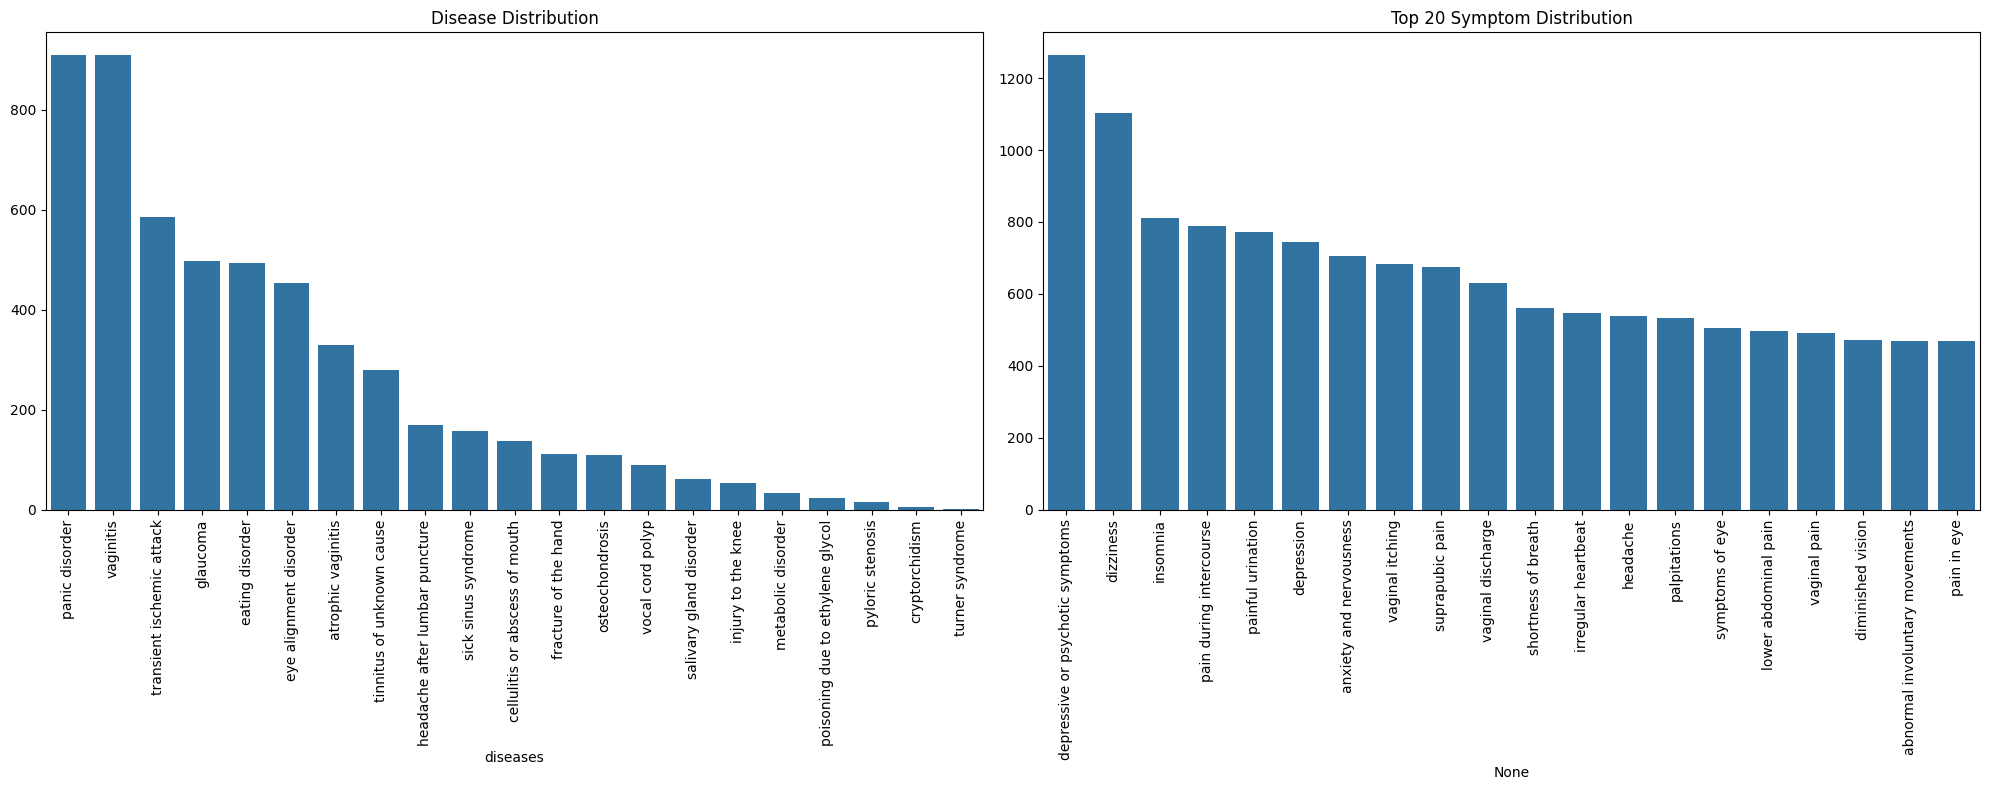

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot disease distribution
sns.barplot(x=disease_distribution.index, y=disease_distribution.values, ax=axes[0])
axes[0].set_title('Disease Distribution')
axes[0].set_xticklabels(disease_distribution.index, rotation=90)

# Plot top 20 symptom distribution
top_symptoms = symptom_counts.head(20)
sns.barplot(x=top_symptoms.index, y=top_symptoms.values, ax=axes[1])
axes[1].set_title('Top 20 Symptom Distribution')
axes[1].set_xticklabels(top_symptoms.index, rotation=90)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

## Preprocess data

### Subtask:
Prepare the data for the machine learning model, which may include encoding categorical variables and splitting the data into training and testing sets.


**Reasoning**:
Separate features and target, encode the target variable, and split the data into training and testing sets, stratifying the split based on the encoded target variable.



In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Separate features (X) and target (y)
X = df.drop('diseases', axis=1)
y = df['diseases']

# Initialize and fit LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets, stratifying by y_encoded
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Data preparation complete.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

**Reasoning**:
The previous step failed because there are classes with only one sample, which prevents stratified splitting. I will remove rows corresponding to diseases with only one sample before splitting the data.



In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Identify diseases with only one sample
disease_counts = df['diseases'].value_counts()
diseases_to_keep = disease_counts[disease_counts >= 2].index

# Filter the DataFrame to keep only diseases with 2 or more samples
df_cleaned = df[df['diseases'].isin(diseases_to_keep)]

# Separate features (X) and target (y) from the cleaned DataFrame
X = df_cleaned.drop('diseases', axis=1)
y = df_cleaned['diseases']

# Initialize and fit LabelEncoder on the cleaned target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets, stratifying by y_encoded
# This should now work as classes with only one sample have been removed
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Data preparation complete after removing rare diseases.")
print(f"Shape of cleaned DataFrame: {df_cleaned.shape}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Data preparation complete after removing rare diseases.
Shape of cleaned DataFrame: (5425, 378)
Shape of X_train: (4340, 377)
Shape of X_test: (1085, 377)
Shape of y_train: (4340,)
Shape of y_test: (1085,)


## Build and train model

### Subtask:
Choose and train a machine learning model for disease prediction.


**Reasoning**:
Import and train an XGBoost classifier on the preprocessed data.



In [11]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import joblib
import numpy as np

# Initialize and train the XGBoost Model
print("Initializing and training the XGBoost Classifier...")
model = xgb.XGBClassifier(
    objective='multi:softmax', # Specifies multi-class classification
    n_estimators=100,          # Number of trees to build
    learning_rate=0.1,         # How much to adjust weights at each step
    max_depth=10,              # Maximum depth of a tree
    use_label_encoder=False,   # Suppresses a deprecation warning
    eval_metric='mlogloss',    # Metric for evaluation
    n_jobs=-1,                 # Use all available CPU cores
    random_state=42
)

model.fit(X_train, y_train)
print("Model training completed!")

# Make Predictions and Evaluate
print("\n--- Model Evaluation ---")
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
# Ensure classification_report uses labels that are actually present in y_test and y_pred
present_labels = np.unique(np.concatenate((y_test, y_pred)))
# We need the label_encoder from the previous step to get the target names
target_names_present = label_encoder.inverse_transform(present_labels)
print(classification_report(y_test, y_pred, labels=present_labels, target_names=target_names_present, zero_division=0))

# Save the Model and Encoder
joblib.dump(model, 'disease_prediction_model_xgb_final.joblib')
joblib.dump(label_encoder, 'disease_label_encoder_final.joblib')
print("High-performance model and encoder saved successfully.")

print("\n--- Process Finished ---")

Initializing and training the XGBoost Classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training completed!

--- Model Evaluation ---
Overall Accuracy: 0.9917

Classification Report:
                                  precision    recall  f1-score   support

              atrophic vaginitis       0.98      0.95      0.97        66
  cellulitis or abscess of mouth       1.00      0.96      0.98        28
                  cryptorchidism       1.00      1.00      1.00         1
                 eating disorder       1.00      0.99      0.99        99
          eye alignment disorder       1.00      1.00      1.00        90
            fracture of the hand       1.00      1.00      1.00        22
                        glaucoma       1.00      1.00      1.00        99
  headache after lumbar puncture       1.00      0.97      0.99        34
              injury to the knee       0.91      1.00      0.95        10
              metabolic disorder       1.00      1.00      1.00         7
                 osteochondrosis       1.00      0.95      0.98        22
          

## Evaluate model

### Subtask:
Evaluate the performance of the trained model using appropriate metrics.


**Reasoning**:
Calculate and print the accuracy score and the classification report using the test set and the model's predictions.



In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Make Predictions
y_pred = model.predict(X_test)

# 1. Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")

# 2. Generate and print the classification report
print("\nClassification Report:")
# Get the unique labels that are actually present in the test and prediction sets
present_labels = np.unique(np.concatenate((y_test, y_pred)))
# Get the corresponding names for these labels from the encoder (label_encoder is available from previous steps)
target_names_present = label_encoder.inverse_transform(present_labels)

# Generate the report using only the labels and names that are actually present
print(classification_report(y_test, y_pred, labels=present_labels, target_names=target_names_present, zero_division=0))

Overall Accuracy: 0.9917

Classification Report:
                                  precision    recall  f1-score   support

              atrophic vaginitis       0.98      0.95      0.97        66
  cellulitis or abscess of mouth       1.00      0.96      0.98        28
                  cryptorchidism       1.00      1.00      1.00         1
                 eating disorder       1.00      0.99      0.99        99
          eye alignment disorder       1.00      1.00      1.00        90
            fracture of the hand       1.00      1.00      1.00        22
                        glaucoma       1.00      1.00      1.00        99
  headache after lumbar puncture       1.00      0.97      0.99        34
              injury to the knee       0.91      1.00      0.95        10
              metabolic disorder       1.00      1.00      1.00         7
                 osteochondrosis       1.00      0.95      0.98        22
                  panic disorder       0.99      1.00      1.0

## Summary:

### Data Analysis Key Findings

*   The dataset contains 5426 entries and 378 columns, with 'diseases' being the target variable and the rest representing symptoms (mostly binary).
*   There is a significant class imbalance in the 'diseases' column, with 'panic disorder' being the most frequent (909 occurrences) and some diseases having only one or two occurrences.
*   The most frequent symptoms include 'depressive or psychotic symptoms', 'dizziness', and 'insomnia'.
*   Visualizations confirmed the uneven distribution of both diseases and symptoms.
*   Diseases with only one sample were removed to enable stratified splitting of the data.
*   An XGBoost classifier model was trained and achieved an overall accuracy of 0.9917 on the test set.
*   The classification report showed high precision, recall, and F1-scores for most disease classes, indicating strong predictive performance.

### Insights or Next Steps

*   The high accuracy suggests that the symptoms provided are highly indicative of the diseases in this dataset.
*   Address the class imbalance in the dataset to potentially improve the model's performance on rare diseases, perhaps using techniques like oversampling or undersampling.


## Combine GUI and logic

### Subtask:
Connect the GUI elements to the prediction function so that user interactions trigger the prediction and display of results.

**Reasoning**:
Attach the `predict_disease` function to the `on_click` event of the `predict_button` and then display the `symptoms_vbox`, `predict_button`, and `output_widget` to the user.

In [32]:
# Link the button click event to the prediction function
predict_button.on_click(predict_disease)

# Display the GUI
# Display the HBox containing checkboxes instead of the VBox
display(symptoms_hbox, predict_button, output_widget)

print("GUI displayed below.")

Button(description='Predict Disease', style=ButtonStyle())

Output()

GUI displayed below.


## Display prediction results

### Subtask:
Update the GUI to show the predicted disease based on the model's output.

**Reasoning**:
The prediction logic is now in place. We need to display the output of the `predict_disease` function to the user. The `output_widget` is designed for this purpose.

In [25]:
# This is handled within the predict_disease function using the output_widget
# The predict_disease function already prints the result to the output_widget
# We just need to make sure the output_widget is displayed as part of the GUI layout
print("Prediction results will be displayed below the predict button.")

Prediction results will be displayed below the predict button.


## Implement prediction logic

### Subtask:
Write a function that takes selected symptoms from the GUI, preprocesses them to match the model's input format, and uses the loaded model to make a prediction.

**Reasoning**:
Define a function that will be triggered by the predict button. This function needs to:
1. Collect the state of each symptom checkbox.
2. Create a feature vector (like the training data) based on the selected symptoms.
3. Use the loaded model to predict the disease based on this feature vector.
4. Use the label encoder to convert the predicted numerical label back to a disease name.

In [31]:
def predict_disease(button):
    """
    Collects selected symptoms from the GUI, makes a prediction
    using the trained model, and displays the result.
    """
    with output_widget:
        output_widget.clear_output()
        print("Predicting...")

        # 1. Collect selected symptoms
        selected_symptoms = [symptom for symptom, checkbox in symptom_widgets.items() if checkbox.value]

        if not selected_symptoms:
            print("Please select at least one symptom.")
            return

        # 2. Create a feature vector (DataFrame row)
        # Initialize a dictionary with all symptom columns and set values to 0
        # Ensure symptom_columns is available (from the GUI creation step)
        if 'symptom_columns' not in globals():
             print("Error: Symptom columns not found. Please run the GUI creation step first.")
             return

        input_data = {symptom: [0] for symptom in symptom_columns}

        # Set the value to 1 for selected symptoms
        for symptom in selected_symptoms:
            if symptom in input_data: # Check if symptom is in the original training columns
                 input_data[symptom][0] = 1
            else:
                # This case should ideally not happen if symptom_columns is correctly loaded
                print(f"Warning: Symptom '{symptom}' not found in training data. Ignoring.")


        # Create a pandas DataFrame with the same column order as the training data
        # This is crucial for the model to make correct predictions
        input_df = pd.DataFrame(input_data, columns=symptom_columns)


        # 3. Make a prediction
        try:
            # Ensure model and label_encoder are available (from the loading step)
            if 'model' not in globals() or 'label_encoder' not in globals():
                 print("Error: Model or label encoder not loaded. Please run the loading step first.")
                 return

            prediction_encoded = model.predict(input_df)
            # 4. Convert the predicted label back to a disease name
            predicted_disease = label_encoder.inverse_transform(prediction_encoded)
            print(f"Predicted Disease: {predicted_disease[0]}")
        except Exception as e:
            print(f"An error occurred during prediction: {e}")

## Create the GUI

### Subtask:
Design and implement the graphical user interface using `ipywidgets`. This will include widgets for symptom selection and a button to trigger prediction.

**Reasoning**:
Create interactive widgets for each symptom in the dataset, allowing the user to select the symptoms they are experiencing. We will use checkboxes for this purpose.

In [30]:
# Get the list of symptom columns from the original dataframe (excluding the 'diseases' column)
# Assuming the original dataframe 'df' is still available from the previous data analysis steps
# If not, you would need to load it or get the column names from the trained model's features
try:
    # Load the dataframe if it's not already in the environment
    if 'df' not in globals():
         df = pd.read_csv('/content/Final_Augmented_dataset_Diseases_and_Symptoms.csv')

    symptom_columns = df.drop('diseases', axis=1).columns.tolist()
except FileNotFoundError:
    print("Error: Dataset file not found. Please make sure 'Final_Augmented_dataset_Diseases_and_Symptoms.csv' is in the correct directory.")
    symptom_columns = [] # Initialize as empty list to prevent further errors
except NameError:
     print("Error: Original dataframe 'df' not found. Please make sure the data loading step was executed or the file path is correct.")
     symptom_columns = [] # Initialize as empty list to prevent further errors
except Exception as e:
    print(f"An error occurred while getting symptom columns: {e}")
    symptom_columns = []


# Create a checkbox for each symptom
symptom_widgets = {
    symptom: widgets.Checkbox(description=symptom, value=False)
    for symptom in symptom_columns
}

# Arrange the checkboxes in an HBox for horizontal layout
# Use list comprehension to create a list of checkboxes
checkboxes = [checkbox for checkbox in symptom_widgets.values()]

# You can group checkboxes in multiple HBoxes if the number of symptoms is large
# For simplicity, we'll put them in one HBox for now, which might require scrolling
symptoms_hbox = widgets.HBox(checkboxes)


# Create a button to trigger the prediction
predict_button = widgets.Button(description="Predict Disease")

# Create an output widget to display the prediction result
output_widget = widgets.Output()

print("GUI elements created.")

GUI elements created.


## Load the trained model and encoder

### Subtask:
Load the saved XGBoost model and the LabelEncoder.

**Reasoning**:
To make predictions with the GUI, we need to load the previously trained model and the label encoder used to transform the target variable.

In [29]:
try:
    model = joblib.load('disease_prediction_model_xgb_final.joblib')
    label_encoder = joblib.load('disease_label_encoder_final.joblib')
    print("Model and encoder loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure 'disease_prediction_model_xgb_final.joblib' and 'disease_label_encoder_final.joblib' are in the correct directory.")
except Exception as e:
    print(f"An error occurred while loading the model or encoder: {e}")

Model and encoder loaded successfully.


# Disease Prediction GUI

This notebook will guide you through creating a simple graphical user interface (GUI) to interact with the trained disease prediction model.

## Set up the environment

### Subtask:
Install necessary libraries for building the GUI (e.g., `ipywidgets`, `sklearn`, `xgboost`, `joblib`).

**Reasoning**:
To build the GUI and use the trained model, we need to install specific Python libraries. `ipywidgets` is for creating interactive elements in the notebook, and the others are for loading and using the previously saved model and encoder.

In [28]:
%pip install ipywidgets sklearn xgboost joblib

import ipywidgets as widgets
from IPython.display import display
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
